In [8]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from deap import base
from deap import creator
from deap import tools
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

In [4]:
# load data
data  = pd.read_csv('C:\\Users\\Amir Hossein\\Desktop\\Project\\dataset\\My-Data.csv')
# data  = data.values
# feat  = np.asarray(data[:, 0:-1])
# label = np.asarray(data[:, -1])

# class for getting the score

In [5]:
class ModelScore:

    def __init__(self, data, model):
        
        
        self.X = data.iloc[:, :-1]
        self.y = data.iloc[:, [-1]]


        # split the data, creating a group of training/validation sets to be used in the k-fold validation process:
#         self.kfold = KFold(n_splits=3)

        pipeline = Pipeline([("scaler", StandardScaler()),
                             ("model", model)])
        self.model = TransformedTargetRegressor(regressor=pipeline,
                                                transformer=StandardScaler())
        self.RKFold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

    def __len__(self):
        """
        :return: the total number of features used in this Regression problem
        """
        return self.X.shape[1]

    def getMeanR2(self, zeroOneList):
        """
        returns the mean r2 measure of the regressor, calculated using repeated-k-fold validation process,
        using the features selected by the zeroOneList
        :param zeroOneList: a list of binary values corresponding the features in the dataset. A value of '1'
        represents selecting the corresponding feature, while a value of '0' means that the feature is dropped.
        :return: the mean R2 measure of the Regressor when using the features selected by the zeroOneList
        """

        # drop the dataset columns that correspond to the unselected features:
        zeroIndices = [i for i, n in enumerate(zeroOneList) if n == 0]
        currentX = self.X.drop(self.X.columns[zeroIndices], axis=1)

        # perform k-fold validation and determine the accuracy measure of the classifier:
        cv_results = cross_val_score(self.model, currentX, self.y, cv=self.RKFold, scoring='r2', n_jobs=-1)

        # return mean accuracy:
        return np.mean(cv_results)

def main():
    # create a problem instance:
    model = LinearRegression()
    lr = ModelScore(data, model)

    allOnes = [1] * len(lr)
    print("-- All features selected: ", allOnes, ", r2 = ", lr.getMeanR2(allOnes))


if __name__ == "__main__":
    main()

-- All features selected:  [1, 1, 1, 1, 1] , r2 =  0.6410870907674352


# LR - PSO

gen	evals	max    	avg    
0  	50   	64.0587	28.6169
1  	50   	64.0587	39.0048
2  	50   	64.0587	42.5633
3  	50   	64.0587	45.0965
4  	50   	64.0587	44.7553
5  	50   	64.0587	40.2089
6  	50   	64.0587	42.4175
7  	50   	64.0587	45.1619
8  	50   	64.0587	48.4472
9  	50   	64.0587	48.9028
10 	50   	64.0587	48.6295
11 	50   	64.0587	47.1492
12 	50   	64.0587	51.509 
13 	50   	64.0587	45.1081
14 	50   	64.0587	52.338 
15 	50   	64.0587	50.8118
16 	50   	64.0587	47.9034
17 	50   	64.0587	54.6229
18 	50   	64.0587	52.6961
19 	50   	64.0587	52.8812
20 	50   	64.0587	47.9874
21 	50   	64.0587	51.656 
22 	50   	64.0587	51.553 
23 	50   	64.0587	52.2725
24 	50   	64.0587	54.2679
25 	50   	64.0587	53.0464
26 	50   	64.0587	52.8018
27 	50   	64.0587	50.2256
28 	50   	64.0587	52.1181
29 	50   	64.0587	49.5077
30 	50   	64.0587	53.6628
31 	50   	64.0587	53.1159
32 	50   	64.0587	54.1167
33 	50   	64.0587	52.4666
34 	50   	64.0587	52.0048
35 	50   	64.0587	53.7771
36 	50   	64.0587	56.8735
37 	50   	64

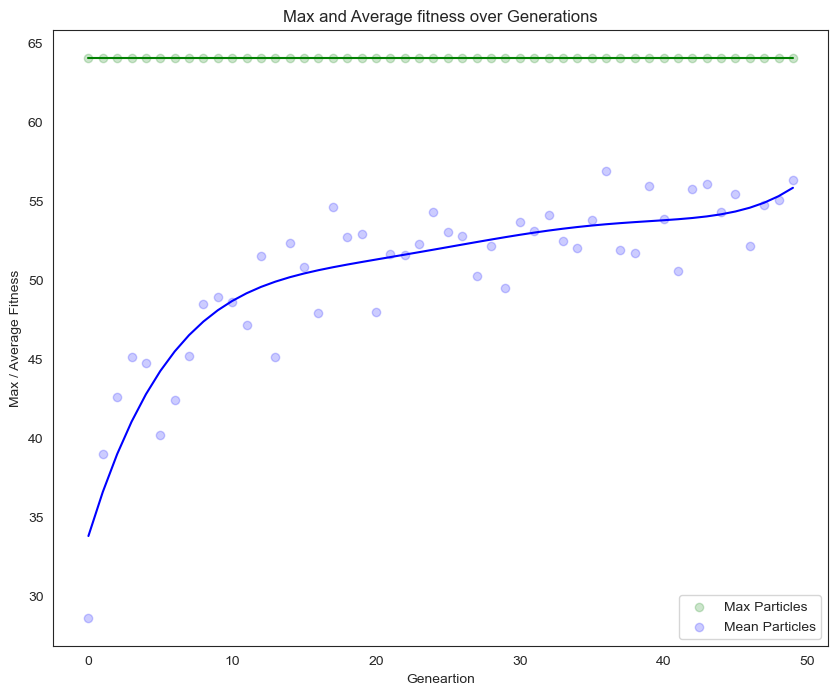

In [14]:
model = LinearRegression()
lr = ModelScore(data, model)

# constants:
DIMENSIONS = len(lr)
POPULATION_SIZE = 50
MAX_GENERATIONS = 50
MIN_START_POSITION, MAX_START_POSITION = 0, 1
MIN_SPEED, MAX_SPEED = -3.0, 3.0
MAX_LOCAL_UPDATE_FACTOR = MAX_GLOBAL_UPDATE_FACTOR = 2.0
FEATURE_PENALTY_FACTOR = 0.01

# set the random seed:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
all_time = list()
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy:
creator.create("FitnessMax", base.Fitness, weights=(+1.0,))

# define the particle class based on ndarray:
creator.create("Particle", np.ndarray, fitness=creator.FitnessMax, speed=None, best=None)
now = timeit.default_timer()
# create and initialize a new particle:
def createParticle():
    particle = creator.Particle(np.random.randint(low=0,
                                                  high=2,
                                                  size=DIMENSIONS))
    particle.speed = np.random.uniform(MIN_SPEED, MAX_SPEED, DIMENSIONS)
    return particle

# create the 'particleCreator' operator to fill up a particle instance:
toolbox.register("particleCreator", createParticle)


# create the 'population' operator to generate a list of particles:
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.particleCreator)


def updateParticle(particle, best):

    # create random factors:
    localUpdateFactor = np.random.randint(0, MAX_LOCAL_UPDATE_FACTOR, particle.size)
    globalUpdateFactor = np.random.randint(0, MAX_GLOBAL_UPDATE_FACTOR, particle.size)

    # calculate local and global speed updates:
    localSpeedUpdate = localUpdateFactor * (particle.best - particle)
    globalSpeedUpdate = globalUpdateFactor * (best - particle)

    # scalculate updated speed:
    particle.speed = particle.speed + (localSpeedUpdate + globalSpeedUpdate)

    # enforce limits on the updated speed:
    particle.speed = np.clip(particle.speed, MIN_SPEED, MAX_SPEED)

    # replace particle position with old-position + speed:
    particle[:] = particle + particle.speed


toolbox.register("update", updateParticle)


def r2_accuracy(particle):
    numFeatureUsed = sum([1 if i !=0 else 0 for i in list(particle)])
    if numFeatureUsed == 0:
        return 0.0,
    else:
        r2_score = lr.getMeanR2(particle)
        return (r2_score * 100) - (numFeatureUsed * FEATURE_PENALTY_FACTOR),


toolbox.register("evaluate", r2_accuracy)



# create the population of particle population:
population = toolbox.populationCreator(n=POPULATION_SIZE)

# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)

logbook = tools.Logbook()
logbook.header = ["gen", "evals"] + stats.fields

best = None

for generation in range(MAX_GENERATIONS):

    # evaluate all particles in polulation:
    for particle in population:

        # find the fitness of the particle:
        particle.fitness.values = toolbox.evaluate(particle)

        # particle best needs to be updated:
        if particle.best is None or particle.best.size == 0 or particle.best.fitness < particle.fitness:
            particle.best = creator.Particle(particle)
            particle.best.fitness.values = particle.fitness.values

        # global best needs to be updated:
        if best is None or best.size == 0 or best.fitness < particle.fitness:
            best = creator.Particle(particle)
            best.fitness.values = particle.fitness.values

    # update each particle's speed and position:
    for particle in population:
        toolbox.update(particle, best)

    # record the statistics for the current generation and print it:
    logbook.record(gen=generation, evals=len(population), **stats.compile(population))
    print(logbook.stream)
# print info for best solution found:
duration = timeit.default_timer() - now
print("-- Best Particle = ", best)
print("-- Best Fitness = ", best.fitness.values[0])
print("Number of Features Selected: %d" % sum([1 if i !=0 else 0 for i in list(best)]))
print("R2 Score Best Particle: %.3f" % lr.getMeanR2(best))

maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

generation = [i for i in range(MAX_GENERATIONS)]
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
sns.set_style("white")
ax = plt.figure(figsize=(10, 8))
ax = plt.axes()
z = np.polyfit(generation,maxFitnessValues,5) 
p = np.poly1d(z)
#     plt.ylim([0.5, 1])
all_time.append(duration)
# print("Time: ", duration)
print("Total Time Consumed: %.3f minutes" % float(sum(all_time)/60))
plt.scatter(generation, maxFitnessValues, marker="o", color="green", alpha=0.2, label="Max Particles")
plt.plot(generation, p(generation), '-', color="green")
plt.scatter(generation, meanFitnessValues, marker="o", color="blue", alpha=0.2, label="Mean Particles")
z_mean = np.polyfit(generation,meanFitnessValues,5) 
p_mean = np.poly1d(z_mean)
plt.plot(generation, p_mean(generation), '-', color="blue")
#     ax.set_facecolor("white")
plt.xlabel("Geneartion")
plt.ylabel("Max / Average Fitness")
plt.title("Max and Average fitness over Generations")
plt.legend(loc=4)
plt.savefig("C:/Users/Amir Hossein/Desktop/Project/Figures//PSO_lr", dpi=1000)
plt.show()

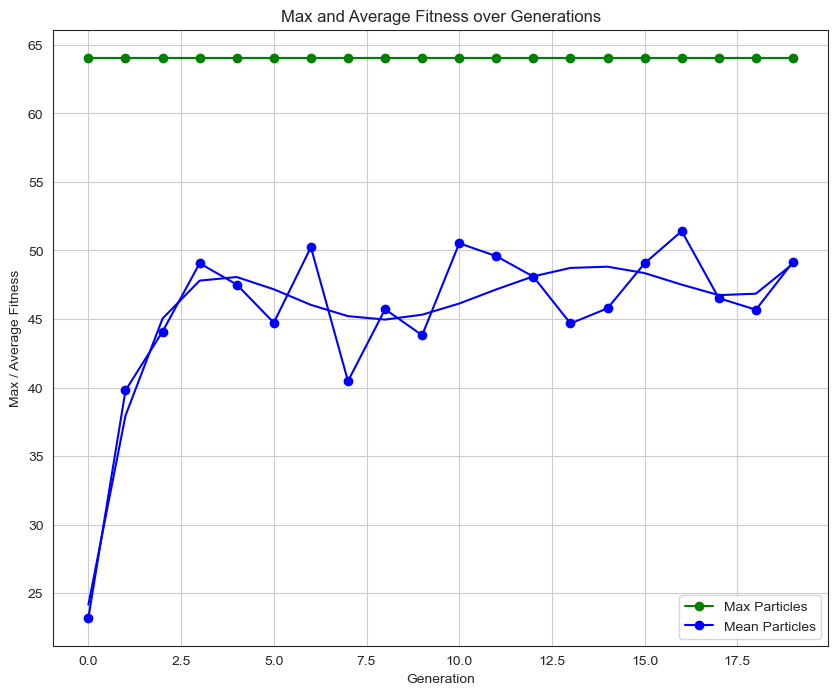

-- Best Particle =  [1 1 1 1 1]
-- Best Fitness =  64.05870907674353
Number of Features Selected: 5
R2 Score Best Particle: 0.641


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

# Your existing code

# Extract fitness values from the logbook
maxFitnessValues, meanFitnessValues = logbook.select("max", "avg")

# Plotting the fitness values over generations
generation = [i for i in range(MAX_GENERATIONS)]

plt.figure(figsize=(10, 8))
sns.set_style("white")

# Plot Max Fitness values
plt.plot(generation, maxFitnessValues, marker="o", color="green", label="Max Particles")
z = np.polyfit(generation, maxFitnessValues, 5)
p = np.poly1d(z)
plt.plot(generation, p(generation), '-', color="green")

# Plot Mean Fitness values
plt.plot(generation, meanFitnessValues, marker="o", color="blue", label="Mean Particles")
z_mean = np.polyfit(generation, meanFitnessValues, 5)
p_mean = np.poly1d(z_mean)
plt.plot(generation, p_mean(generation), '-', color="blue")

plt.xlabel("Generation")
plt.ylabel("Max / Average Fitness")
plt.title("Max and Average Fitness over Generations")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Display information about the best particle
print("-- Best Particle = ", best)
print("-- Best Fitness = ", best.fitness.values[0])
print("Number of Features Selected: %d" % sum([1 if i != 0 else 0 for i in list(best)]))
print("R2 Score Best Particle: %.3f" % lr.getMeanR2(best))
